<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Getting-the-Data" data-toc-modified-id="Getting-the-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Getting the Data</a></span></li><li><span><a href="#Statistics-of-the-Dataset" data-toc-modified-id="Statistics-of-the-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Statistics of the Dataset</a></span></li><li><span><a href="#Splitting-the-dataset" data-toc-modified-id="Splitting-the-dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Splitting the dataset</a></span></li><li><span><a href="#Loading-the-data" data-toc-modified-id="Loading-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Loading the data</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Exercises" data-toc-modified-id="Exercises-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Exercises</a></span></li></ul></div>

추천 연구에서 사용할 수 있는 데이터 세트가 많이 있습니다. 그 중 [MovieLens 데이터 세트](https://movielens.org/) 는 아마도 가장 인기 있는 데이터 세트 중 하나일 것입니다. MovieLens는 비상업적인 웹 기반 영화 추천 시스템입니다. 1997년에 만들어졌으며 연구 목적으로 영화 등급 데이터를 수집하기 위해 미네소타 대학의 연구소인 GroupLens에서 운영합니다. MovieLens 데이터는 개인화된 추천 및 사회 심리학을 포함한 여러 연구 분야에서 중요하게 사용되어왔습니다.

## Getting the Data

MovieLens 데이터 세트는 GroupLens 웹 사이트에서 호스팅됩니다. 여러 버전을 사용할 수 있습니다. MovieLens 100K 데이터 세트를 사용할 것입니다[Herlocker et al., 1999]. 이 데이터 세트는 1,682편의 영화에 대해 943명의 사용자로부터 1에서 5까지의 범위로 100,000개의 평점으로 구성됩니다. 각 사용자가 최소 20편의 영화를 평가할 수 있도록 정리되었습니다. 사용자의 연령, 성별, 장르 및 항목과 같은 간단한 인구 통계 정보도 사용할 수 있습니다. ml-100k.zip을 다운로드하고 100,000개 모두가 포함된 `u.data` 파일을 추출할 수 있습니다.

csv 형식의 평점. 폴더에는 다른 많은 파일이 있으며 각 파일에 대한 자세한 설명은 데이터 세트의 `README` 파일에서 찾을 수 있습니다.

먼저 이 섹션의 실험을 실행하는 데 필요한 패키지를 가져오겠습니다.

In [1]:
import os
import pandas as pd
from mxnet import gluon, np
from d2l import mxnet as d2l

그 다음,  MovieLens 100k 데이터 세트를 다운로드하고 데이터 프레임 형식으로 로드해보겠습니다.

In [2]:
#@save
d2l.DATA_HUB['ml-100k'] = (
    'http://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

#@save
def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

## Statistics of the Dataset

데이터를 로드하고 처음 5개의 행을 확인해보겠습니다. 데이터 구조를 확인해볼 수 있는 효과적인 방법입니다.

In [3]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))

number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


각 행은 `user id` 1-943, `item id` 1-1682, `rating` 1-5 및 `timestamp`를 포함한 4개의 열로 구성되어 있음을 알 수 있습니다. n×m 크기의 interaction 행렬을 구성할 수 있습니다.
여기서 n과 m은 각각 사용자 수와 아이템 수입니다. 이 데이터세트는 평점만 기록하므로 평점 행렬이라고도 하며, 이 행렬의 값이 정확한 평점을 나타내는 경우 interaction 행렬이나 평점 행렬로 사용될 것입니다. 평점 행렬에서 대부분의 값이 사용자가 대다수의 영화를 평가하지 않았기 때문에 아직 알 수 없습니다. 

또한 데이터 세트의 희소성을 확인할 수 있습니다. 희소성은 $1 - 0이 아닌 항목 수 / ( 사용자 수 * 항목 수)$로 정의됩니다. 명확히 interaction 행렬은 극도로 희소합니다(즉, 희소성 = 93.695%). 

실제 데이터 세트는 더 큰 희소성으로 인해 어려움을 겪을 수 있으며 추천 시스템을 구축하는 데 있어 오랜 과제였습니다. 실행 가능한 솔루션은 희소성을 완화하기 위해 사용자/아이템과 같은 추가적인 부가정보를 사용하는 것입니다.

그 다음 서로 다른 평점의 빈도수로 분포를 그려볼 수 있습니다. 예상한대로 대부분의 평점의 중심이 3~4을 가지는 정규분포로 보입니다.

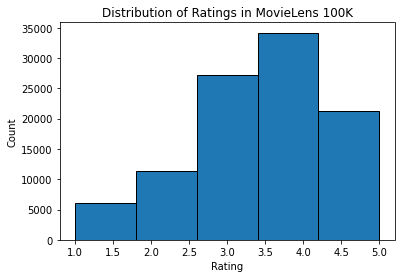

In [4]:
d2l.plt.hist(data['rating'], bins=5, ec='black')
d2l.plt.xlabel('Rating')
d2l.plt.ylabel('Count')
d2l.plt.title('Distribution of Ratings in MovieLens 100K')
d2l.plt.show()

## Splitting the dataset

데이터 세트를 훈련 세트와 테스트 세트로 나눕니다. 다음으로는 random 및 seq-aware를 포함한 두 가지 분할 모드를 제공합니다. 

random 모드에서 함수는 타임스탬프를 고려하지 않고 100,000개의 interaction을 무작위로 분할하고 기본적으로 데이터의 90%를 훈련 샘플로 사용하고 나머지 10%를 테스트 샘플로 사용합니다. 

seq-aware 모드에서는 테스트를 위해 사용자가 가장 최근에 평가한 아이템을 남겨두고, 사용자의 과거 interaction을 훈련 세트로 두게 됩니다. 사용자의 interaction 기록은 타임스탬프를 기반으로 가장 오래된 것부터 최신 순서로 정렬됩니다. 이 모드는 sequence-aware recommendation 섹션에서 사용됩니다.

In [5]:
#@save
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

테스트 세트와 별도로 검증 세트를 실제로 사용하는 것이 좋습니다. 그러나 간결함을 위해 생략합니다. 이 경우 테스트 세트는 held-out 검증 세트로 간주될 수 있습니다.

## Loading the data

데이터셋 분할 후, 편의를 위해 훈련 세트와 테스트 세트를 리스트와 사전/행렬로 변환합니다. 다음 함수는 데이터 프레임을 한 줄씩 읽고 0부터 시작하는 사용자/아이템의 인덱스를 열거합니다. 그런 다음 함수는 사용자, 아이템, 평점, interaction을 기록하는 사전/행렬 목록을 반환합니다. 명시적 또는 암묵적 피드백 유형을 지정할 수 있습니다.

In [6]:
#@save
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

그런 다음 위의 단계를 통합하고 다음 섹션에서 사용합니다. 결과는 Dataset 및 DataLoader로 wrapping됩니다. 학습 데이터에 대한 DataLoader의 마지막 배치는 rollover 모드로 설정되고(나머지 샘플은 다음 epoch로 rollover 됨.) 순서가 뒤섞입니다.

In [7]:
#@save
def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    
    train_data, test_data = split_data_ml100k(data, num_users, num_items, split_mode, test_ratio)
    
    train_u, train_i, train_r, _ = load_data_ml100k(train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(test_data, num_users, num_items, feedback)
    
    train_set = gluon.data.ArrayDataset(np.array(train_u), np.array(train_i), np.array(train_r))
    test_set = gluon.data.ArrayDataset(np.array(test_u), np.array(test_i), np.array(test_r))
    
    train_iter = gluon.data.DataLoader(train_set, shuffle=True, last_batch='rollover', batch_size=batch_size)
    test_iter = gluon.data.DataLoader(test_set, batch_size=batch_size)
    return num_users, num_items, train_iter, test_iter

## Summary

MovieLens 데이터세트는 추천 분야에서 널리 사용됩니다. 이는 무료로 누구나 사용할 수 있습니다.

이후 섹션에서 나중에 사용할 수 있도록 MovieLens 100k 데이터 세트를 다운로드하고 사전 처리하는 함수를 정의합니다.

## Exercises

- What other similar recommendation datasets can you find?

- Go through the https://movielens.org/ site for more information about MovieLens.